In [1]:
%load_ext autoreload
%autoreload 2

## Обучение рекомендательной системы для симулированных пользователей

Вы разработчик рекомендательной системы в онлайн-кинотеатре "Поиск фильмов". У вас есть десять фильмов, и при входе на сайт кинотеатра вы предлагаете пользователю один из них. Если пользователь увидит на баннере фильм, который ему нравится, он с большой вероятностью на него кликнет (оставит положительный отклик на рекомендацию). Мы изучили какой контекст всего влияет на предпочтения пользователей и собрали самые важные признаки. У нас есть по 4 признака по каждому товару (фильму) и пользователю. Вам нужно обучить рекомендательную модель, максимизирующую количество кликов по баннерам. У вас нет исторических данных, но доступен симулятор, генерирующий отклики пользователей на рекомендации, который поможет получить данные в интерактивном режиме.


### Пользователи
3000 анонимных пользователей

### Товары
10 фильмов

### Задача
Построить контекстуальную рекомендательную модель, которая даст наибольшее количество кликов

### Доступные данные
Пользователи будут реагировать на ваши рекомендации в интерактивном режиме. Вы получаете список пользователей, для каждого из которых нужно подготовить по 1 рекомендации. Модель отклика симулятора генерирует отклики на рекомендации, которые вы можете использовать для обучения рекомендательной системы. Мы не "прячем" от вас модель отклика, но просим не использовать ее и ее данные, в своем решении. В данной задаче вы обладаете дополнительной информацией о пользователях и товарах.

## Симулятор
Симулятор Sim4Rec разработан Сбером для моделирования взаимодействия пользователей с рекомендательными системами. Ниже представлена схема цикла симуляции для обучения и тестирования рекомендательных систем в нашем симуляторе.

<img src="./images/simulation_cycle.png">

Для симуляции могут использоваться реальные и синтетические профили (признаки/фичи) пользователей (users) и товаров (items).
Использование синтетических данных позволяет сохранить приватность реальных клиентов и смоделировать более разнообразные ситуации (например, сгененрировать больше пользователей из какой-то группы/кластера).

(1) После генерации популяции товаров и пользователей можно запускать цикл симуляции.
На первом этапе мы выбираем пользователей, который будут взаимодействовать с рекомендательной системой на данной итерации. Это могут быть все пользователи или какая-то их часть.

(2) Затем мы можем выбрать товары, которые будут доступны для пользователей. В базовом варианте, который и будет реализован в наших заданиях, все товары доступны для всех пользователей. Но в реальной жизни какие-то товары могут отсутствовать, могут быть недоступны пользователям из-за ограничений, или же наоборот, мы может формировать персональные предложения для пользователей на этом этапе. 

(3) Следом начинается работа рекомендательная система, которая генерирует для пользователей рекомендуемые товары. Мы будем рассматривать задачу генерации top-k наиболее релевантных товаров для пользователя.

(4) Рекомендации возвращаются в симулятор, который генерируют отклик пользователей на увиденные рекомендации. Это могут быть лайки, добавление в избранное, факт покупки, время просмотра. В реальной задаче пользователь может давать отклики разных типов, мы будем рассматривать только один тип отклика (например, покупку).

(5) Рекомендательная система обновляется с учетом информации об откликах, полученных на текущей итерации цикла симуляции.

Ваша задача - написать алгоритм рекомендательной системы, который даст наибольшее количество положительных откликов на пользователя. Алгоримтм будет обучаться в цикле симуляции N итераций, а на N + 1 итерации будет оцениваться качество рекомендаций в метрике Precision@K (среднее число кликов из top-K рекомендаций у пользователя).

## Импорты и настройки

In [2]:
import os
import sys
os.environ["PYSPARK_PYTHON"]=sys.executable
os.environ["PYSPARK_DRIVER_PYTHON"]=sys.executable

In [3]:
import time

import numpy as np
import pandas as pd
import pyspark.sql.functions as sf
from pyspark.sql import SparkSession

from replay.models import UCB
from replay.session_handler import State
from replay.utils import convert2spark

# укажите путь к tmp-папке spark и директории с чекпоинтами симулятора.
SPARK_LOCAL_DIR = './tmp/task_2'
CHECKPOINTS_DIR = './tmp/task_2_checkpoints'

/home/alexgrish/miniconda3/envs/sim4rec/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
from sim4rec.modules import Simulator, RealDataGenerator

from response_models.task_2_context import TaskTwoResponse
from utils import plot_metric, calc_metric

In [5]:
# если вы не работали со Spark ранее, оставьте настройки сессии неизменными
NUM_THREADS = 4

spark = SparkSession.builder\
    .appName('simulator')\
    .master(f'local[{NUM_THREADS}]')\
    .config('spark.sql.shuffle.partitions', f'{NUM_THREADS * 3}')\
    .config('spark.default.parallelism', f'{NUM_THREADS * 3}')\
    .config('spark.driver.extraJavaOptions', '-XX:+UseG1GC')\
    .config('spark.executor.extraJavaOptions', '-XX:+UseG1GC')\
    .config('spark.local.dir', SPARK_LOCAL_DIR)\
    .getOrCreate()
State(spark)
spark.sparkContext.setLogLevel("ERROR");

23/07/16 23:50:14 WARN Utils: Your hostname, trans4rec resolves to a loopback address: 127.0.1.1; using 192.168.1.13 instead (on interface ens160)
23/07/16 23:50:14 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
23/07/16 23:50:15 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
Using Spark's default log4j profile: org/apache/spark/log4j-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
23/07/16 23:50:15 WARN SparkConf: Note that spark.local.dir will be overridden by the value set by the cluster manager (via SPARK_LOCAL_DIRS in mesos/standalone/kubernetes and LOCAL_DIRS in YARN).
23/07/16 23:50:16 WARN Utils: Service 'SparkUI' could not bind on port 4040. Attempting port 4041.
23/07/16 23:50:16 WARN Utils: Service 'SparkUI' could not bind on port 4041. Attempting port 4042.
23/07/16 23:50:16

In [6]:
NUM_ITEMS = 10
NUM_USERS = 3000
# число рекомендаций, генерируемых рекомендательной системой на пользователя на одной итерации
K = 1
# количество итераций
NUM_ITER = 20
SEED = 1234

## Исходные данные

В нашем распоряжении есть id пользователей и товаров.

In [7]:
users_df = pd.read_parquet('response_models/data/users_context.parquet')
items_df = pd.read_parquet('response_models/data/items_context.parquet')

Создадим словарь `inv_label_encoding_dict`, который далее может быть полезен для контекстуальной модели.

In [8]:
label_encoding_dict = dict(zip(items_df['item_idx'], range(10)))
inv_label_encoding_dict = {value: key for key, value in label_encoding_dict.items()}

In [9]:
users = convert2spark(users_df)
items = convert2spark(items_df)

Симулятор позволяет использовать реальные данные о пользователях и товарах (фичи) и синтетические (сгенерированные на основе реальных). В этой задаче в нашем распоряжении есть только id пользователей и товаров, генерация синтетических данных в этой задаче не актуальна. Поэтому мы будем использовать реальные данные и сэмплировать из них с использованием RealDataGenerator.

In [10]:
item_generator = RealDataGenerator(label='items_real', seed=SEED)
user_generator = RealDataGenerator(label='users_real', seed=SEED)

# передадим популяции пользователей и айтемов
item_generator.fit(items)
user_generator.fit(users)

# будем использовать всех пользователей и айтемы из популяции
item_generator.generate(NUM_ITEMS)
user_generator.generate(NUM_USERS)

DataFrame[user_idx: bigint, user_feature_0: double, user_feature_1: double, user_feature_2: double, user_feature_3: double]

# Пройдем одну итерацию цикла симуляции поэтапно

## (1) Выбор пользователей

In [11]:
# генератор позволяет сэмплировать выбранную долю пользователей от общего количества. 
# Из-за особенностей spark это количество не будет точным. Ниже будет выбрано около 300 пользователей.
user_generator.sample(0.1).count()

305

## (2) Выбор товаров

В цикле симуляции вам будут доступны все 10 айтемов на каждой итерации.

## (3) Инициализация рекомендательной модели

Ваша задача - написать код рекомендательной модели, инициализировать модель здесь и использовать в цикле обучения ниже.

Модель должна принимать на вход список пользователей и товаров и возвращать для каждого пользователя top-K самых релевантных для него товаров в виде датафрейма в формате <user_idx int, item_idx int, relevance double>.

Контекстуальная модель может принимать на вход и использовать дополнительную информацию: предыдущую историю взаимодействия выбранных пользователей с рекомендательной системой и признаки пользователей и айтемов.

Мы предлагаем вам baseline (UCB) из нашей библиотеки RePlay.

Модель UCB - неперсонализированный алгоритм, оценивающий релевантность товаров по верхней границе доверительного интервала. В момент построения рекомендаций модель сэмплирует top-K айтемов для каждого пользователя с вероятностью, пропорциональной рассчитанным релевантностям. Узнать больше об алгоритме UCB и посмотреть пример реализации можно [здесь](https://medium.com/analytics-vidhya/multi-armed-bandit-analysis-of-upper-confidence-bound-algorithm-4b84be516047).

### Baseline модель

In [12]:
model = UCB(sample=True, seed=SEED, exploration_coef=0.5)

# Модель из RePlay нужно обучить на исторических данных, прежде чем можно будет обучать ее дальше в цикле 
# Обойдем это ограничение, представив, что в истории было одно взаимодействие
model.fit(log=users.limit(1).crossJoin(items.limit(1)).withColumn("relevance", sf.lit(1)))

In [13]:
pred = model.predict(log=None, users=users.limit(6), items=items, k=1)
pred.show()

+--------+--------+---------+
|user_idx|item_idx|relevance|
+--------+--------+---------+
|       1|    2959|      0.1|
|       2|       2|      0.1|
|       3|    1721|      0.1|
|       4|    2706|      0.1|
|       5|    1721|      0.1|
|       6|    1270|      0.1|
+--------+--------+---------+



## (4) Модель отклика

Модель отклика принимает датафрейм с колонками <user_idx, item_idx, relevance>, где relevance - оценка релевантности рекомендательной системы и возвращает датафрейм с обязательными колонками <user_idx, item_idx, relevance, response>, добавляя к исходным данным столбец с откликами (response). Если в датафрейме, поданном на вход в модель отклика, были признаки, они также будут возвращены.

In [14]:
context_model = TaskTwoResponse(
    spark, boost_df_path='response_models/data/context_items_relevance.parquet', seed=SEED
)

Посмотрим на примере, как формируется отклик для пары пользователь-товар

In [15]:
test_response = context_model.transform(pred)
test_response.show()

+--------+--------+---------+--------+
|item_idx|user_idx|relevance|response|
+--------+--------+---------+--------+
|    2959|       1|      0.1|       0|
|       2|       2|      0.1|       0|
|    1721|       3|      0.1|       0|
|    2706|       4|      0.1|       0|
|    1721|       5|      0.1|       1|
|    1270|       6|      0.1|       1|
+--------+--------+---------+--------+



## (5) Дообучение рекомендательной модели
После получения откликов на рекомендации можно дообучать рекомендательную модель. В примере выше бинарный отклик находится в колонке response, а модель принимает на вход историю взамодействия (log) в виде датафрейма со столбцами <user_idx, item_idx, relevance>. Т.е. нам нужно будет выбрать нужные столбцы из истории и переименовать repsonse в relevance. Обратите внимание, что если ваша модель использует признаки, они могут быть переданы в модель как отдельные параметры при инициализации или быть добавлены в log в виде отдельных колонок. Вы можете реализовать дообучение модели на новых данных на каждой итерации или полностью переобучать модель на всех данных, имеющихся в логе симулятора `sim.log`. Здесь будет пример с дообучением, а в цикле ниже будем использовать переобучение на всех данных.

In [16]:
new_log = test_response.drop("relevance").withColumnRenamed("response", "relevance")
new_log.show()

+--------+--------+---------+
|item_idx|user_idx|relevance|
+--------+--------+---------+
|    2959|       1|        0|
|       2|       2|        0|
|    1721|       3|        0|
|    2706|       4|        0|
|    1721|       5|        1|
|    1270|       6|        1|
+--------+--------+---------+



In [17]:
### YOUR CODE HERE
model.refit(log=test_response.drop("relevance").withColumnRenamed("response", "relevance"))
###

## (6) Оценка качества рекомендаций
Оценка качества будет выполняться по среднему числу положительных откликов на пользователя.

In [18]:
calc_metric(test_response)

0.3333333333333333

# Обучение модели в симуляторе

Перейдем непосредственно к циклу симуляции. Инициализируем симулятор и все нужные для симуляции модели. Обратите внимание, что если вы захотите перезапустить эксперимент, нужно будет выбрать другую папку для сохранения данных `data_dir` или удалить с диска результаты предыдущего эксперимента. Либо вы можете продолжить эксперимент с новой итерации (например, последней была выполнена 10 итерация, значит цикл нужно продолжить с 11-ой). 

Начнем с уже знакомой модели UCB, не использующей дополнительные признаки.

### Baseline (UCB)

#### Повторно инциализируем компоненты симулятора

In [19]:
!rm -r $CHECKPOINTS_DIR

user_generator.initSeedSequence(SEED)
item_generator.initSeedSequence(SEED)

sim = Simulator(
    user_gen=user_generator,
    item_gen=item_generator,
    user_key_col='user_idx',
    item_key_col='item_idx',
    spark_session=spark,
    data_dir=CHECKPOINTS_DIR,
)

#### Инициализация вашей рекомендательной модели

In [20]:
model = UCB(sample=True, seed=SEED, exploration_coef=0.1)
# Модель из RePlay нужно обучить на исторических данных, прежде чем можно будет обучать ее дальше в цикле 
# Обойдем это ограничение, представив, что в истории было одно взаимодействие
model.fit(log=users.limit(1).crossJoin(items.limit(1)).withColumn("relevance", sf.lit(1)))

#### Инициализация функции отклика

In [21]:
context_model = TaskTwoResponse(
    spark, boost_df_path='response_models/data/context_items_relevance.parquet', seed=SEED
)

#### Цикл симуляции

In [22]:
# # если вы запустили цикл симуляции и остановили его до окончания выполнения, выполните unpersist датафреймов
# current_users.unpersist()
# if log is not None:
#     log.unpersist()
# recs.unpersist()
# true_resp.unpersist()
# train_log.unpersist()

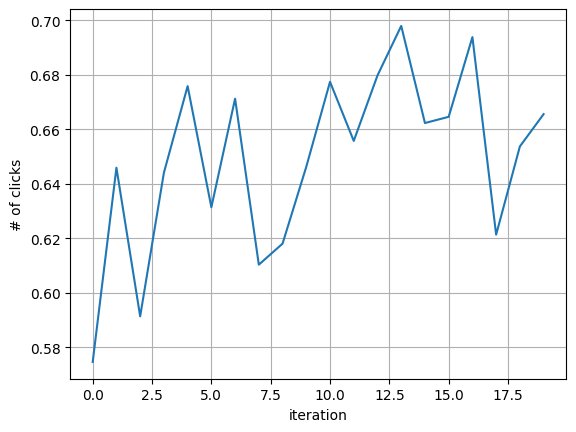

Iteration 19 finished in 9.49141526222229 sec.


In [23]:
metrics = []
for i in range(NUM_ITER):
    print(f'Iteration {i} started')
    iter_time = time.time()
    # выбираем пользователей, которые делают покупки на данной итерации
    current_users = sim.sample_users(0.1).cache()
    # получаем историю их взаимодействия с симулятором в прошлом
    log = sim.get_log(current_users)
    

    ### YOUR CODE HERE: порекомендуйте top-K товаров для каждого пользователя из current_users
    recs = model.predict(
       log=log,
       k=K,
       users=current_users.select("user_idx"),
       items=items,
       filter_seen_items=False
    )

    assert (recs
            .groupBy('user_idx')
            .agg(sf.count("item_idx").alias("num_items"))
            .filter(sf.col("num_items") == sf.lit(K))
            .count() 
            == 
            current_users.count()
           )

    # получаем отклики на рекомендации
    true_resp = sim.sample_responses(
        recs_df=recs,
        user_features=current_users,
        item_features=items,
        action_models=context_model,
    ).select('user_idx', 'item_idx', 'relevance', 'response').cache()

    # записываем историю взаимодействия пользователей с рекомендательной системой на этой итерации
    sim.update_log(true_resp, iteration=i)
    
    # оцениваем качество
    metrics.append(calc_metric(true_resp))

    ### YOUR CODE HERE: дообучите рекомендательную модель на новых данных
    model._clear_cache()
    train_log = sim.log.cache()
    model.fit(
        log=
            train_log.select('user_idx', 'item_idx', 'response')\
                     .withColumnRenamed('response', 'relevance')
    )
    ###

    current_users.unpersist()
    if log is not None:
        log.unpersist()
    recs.unpersist()
    true_resp.unpersist()
    train_log.unpersist()
    
    plot_metric(metrics)
    print(f'Iteration {i} finished in {time.time() - iter_time} sec.')

### LinUCB

Вам доступна заготовка для контекстуальной модели LinUCB. В данном варианте (disjoint LinUCB) считается что параметры функции отклика уникальны для каждого фильма. Узнать больше можно в [оригинальной статье](https://arxiv.org/pdf/1003.0146.pdf) и [блоге](https://kfoofw.github.io/contextual-bandits-linear-ucb-disjoint)

#### Повторно инциализируем компоненты симулятора

In [ ]:
!rm -r $CHECKPOINTS_DIR

user_generator.initSeedSequence(SEED)
item_generator.initSeedSequence(SEED)

sim = Simulator(
    user_gen=user_generator,
    item_gen=item_generator,
    user_key_col='user_idx',
    item_key_col='item_idx',
    spark_session=spark,
    data_dir=CHECKPOINTS_DIR,
)

#### Инициализация вашей рекомендательной модели

<img src="images/LinUCB.png" width=500>

In [ ]:
class Arm():
    def __init__(self, alpha, d):
        self.alpha = alpha
        self.A = np.identity(d)
        self.b = np.ones(d)

    def fit_prob(self, x):
        ### YOUR CODE HERE
        raise NotImplementedError
        ###

    def update_arm(self, r, x):
        ### YOUR CODE HERE
        raise NotImplementedError
        ###


class DisjointLinUCB():
    def __init__(self, items, alpha, d=4, num_arms=10):
        self.num_arms = num_arms
        self.arms = [Arm(alpha=alpha, d=d) for j in range(num_arms)]

    def predict(self, x):
        ### YOUR CODE HERE
        raise NotImplementedError
        ###

In [ ]:
test_model = DisjointLinUCB(items_df, alpha=1.0)

x = users_df.iloc[0, 1:]

pred = test_model.predict(x)
test_model.arms[prediction].update_arm(0, x)
pred = test_model.predict(x)

# не забудьте with ties broken arbitrarily
assert prediction2 != prediction

In [ ]:
### YOUR CODE HERE: инициализация модели
# model = 
###

#### Инициализация функции отклика

In [ ]:
context_model = TaskTwoResponse(
    spark, boost_df_path='response_models/data/boosting_response_df.parquet', seed=SEED
)

#### Цикл симуляции

In [ ]:
# # если вы запустили цикл симуляции и остановили его до окончания выполнения, выполните unpersist датафреймов
# current_users.unpersist()
# if log is not None:
#     log.unpersist()
# recs.unpersist()
# true_resp.unpersist()
# train_log.unpersist()

In [ ]:
metrics = []
for i in tqdm.auto.tqdm(range(NUM_ITER)):
    print(f'Iteration {i} started')
    iter_time = time.time()
    # выбираем пользователей, которые делают покупки на данной итерации
    current_users = sim.sample_users(0.1).cache()
    # получаем историю их взаимодействия с симулятором в прошлом
    log = sim.get_log(current_users)

    ### YOUR CODE HERE: порекомендуйте top-K товаров для каждого пользователя из current_users
    raise NotImplementedError
    ###

    assert (recs
            .groupBy('user_idx')
            .agg(sf.count("item_idx").alias("num_items"))
            .filter(sf.col("num_items") == sf.lit(K))
            .count() 
            == 
            current_users.count()
           )

    # получаем отклики на рекомендации
    true_resp = sim.sample_responses(
        recs_df=recs,
        user_features=current_users,
        item_features=items,
        action_models=context_model,
    ).select('user_idx', 'item_idx', 'relevance', 'response').cache()

    # записываем историю взаимодействия пользователей с рекомендательной системой на этой итерации
    sim.update_log(true_resp, iteration=i)
    
    # оцениваем качество
    metrics.append(calc_metric(true_resp))

    ### YOUR CODE HERE: дообучите рекомендательную модель на новых данных
    raise NotImplementedError
    ###

    current_users.unpersist()
    if log is not None:
        log.unpersist()
    recs.unpersist()
    true_resp.unpersist()
    
    plot_metric(metrics)
    print(f'Iteration {i} finished in {time.time() - iter_time} sec.')

## Финальный результат

In [ ]:
### YOUR CODE HERE: порекомендуйте top-K товаров для каждого пользователя из current_users
recs = model.predict(
    log=sim.log,
    k=K,
    users=users,
    items=items,
    filter_seen_items=False
).cache()
###

assert (recs
        .groupBy('user_idx')
        .agg(sf.count("item_idx").alias("num_items"))
        .filter(sf.col("num_items") == sf.lit(K))
        .count() == users.count()
       )

In [ ]:
# получаем отклики на рекомендации
true_resp = sim.sample_responses(
    recs_df=recs,
    user_features=users,
    item_features=items,
    action_models=response_model
).cache()

# оцениваем качество
print(f"Среднее число купленных товаров на пользователя после обучения модели = {calc_metric(true_resp)}")

In [ ]:
recs.unpersist()
true_resp.unpersist();

# Исследовательские задачки

1. Реализуйте алгоритм disjoint LinUCB, замерьте качество на симуляторе
2. Проанализируйте влияние контекста на рекомендации
- Сравните среднее число кликов, достигаемое к последней итерации алгоритмами, оцените влияние гиперпараметров
- Увеличивают ли метрику признаки айтемов?
- Визуализируйте веса разных признаков
- Для каждого айтема визуализируйте оценку награды на каждой итерации
- Какой item наиболее часто рекомендуется, насколько это логично?

---

---

3. Предложите дополнительные методы визуализации. 
Ссылки для вдохновения:

- https://gdmarmerola.github.io/ts-for-bernoulli-bandit
- https://gdmarmerola.github.io/ts-for-contextual-bandits

4. Попробуйте больше контекстуальных моделей

- Hybrid LinUCB
- [hLinUCB](https://www.cs.virginia.edu/~hw5x/paper/lfp1145-Wang.pdf)
- ...